# Smarticle Experimental Data Visualization
### Notebook Author: Thomas A. Berrueta
In this notebook, I'll illustrate how to access and manipulate the smarticle experimental data. The goal of this notebook is to sufficiently demonstrate how to interact with the published smarticle data.

In [1]:
%load_ext autoreload
%autoreload 2

## Imports and Load Data

In [2]:
from utils import *
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

########################
# Load experimental data
# filename = 'DriveA/DriveA_0pc/destab_driveA_0pc_randinit_1_noisevar_noclip_10_gaitdur_480_numinits_10.csv'
filename = 'Drive3/destab_drive3_randinit_2_noisevar_noclip_10_gaitdur_480_numinits_10.csv'
data = np.genfromtxt(filename,delimiter=',')

## Scaling Data
Here we take the raw AprilTag pixel coordinates and center them at the centroid of the smarticles. Then we scale the coordinates by the smarticle body lengths.

In [3]:
num_smarts = 3
body_len_px = 53.54 # number of pixels corresponding to a smarticle body length
t_data = data[:,1] # time vector
t_sync = data[:,0] # time corresponding to beginning of each 
states = data[:,2:] # state vectors
x_unscaled = states[:,::3]
y_unscaled = states[:,1::3]
theta = states[:,2::3]
centroid = np.array([np.mean(x_unscaled,axis=1),np.mean(y_unscaled,axis=1)])
origin = np.array([np.mean(centroid[0]),np.mean(centroid[1])])

# Scaled data
x = (x_unscaled-origin[0])/body_len_px
y = (y_unscaled-origin[1])/body_len_px

## Trajectory Plots
These are the raw recorded trajectories scaled down to arbitrary units of smarticle body lengths. There are several different initializations of the experimental system included in these trajectories. Each of which begins with several minutes of randomized driving.

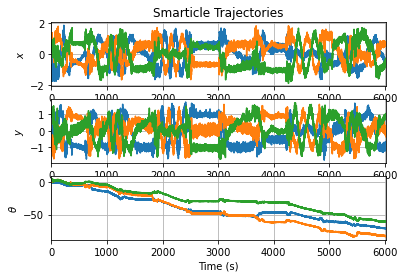

In [4]:
plt.figure()
plt.subplot(3,1,1)
plt.title('Smarticle Trajectories')
plt.plot(t_data,x)
plt.xlim([t_data[0], t_data[-1]])
plt.ylabel(r'$x$')
plt.grid(True)

plt.subplot(3,1,2)
plt.plot(t_data,y)
plt.xlim([t_data[0], t_data[-1]])
plt.ylabel(r'$y$')
plt.grid(True)

plt.subplot(3,1,3)
plt.plot(t_data,theta)
plt.xlim([t_data[0], t_data[-1]])
plt.ylabel(r'$\theta$')
plt.xlabel('Time (s)')
plt.grid(True)
plt.show()

## Calculating Rattling Over Trajectories
Here we calculate rattling over windows in time of our experimental trajectories and display them. The randomizations at the beginning of each trial are intentionally left in to indicate that when we randomize the drive rattling increases as expected.

Wall time: 6.37 s


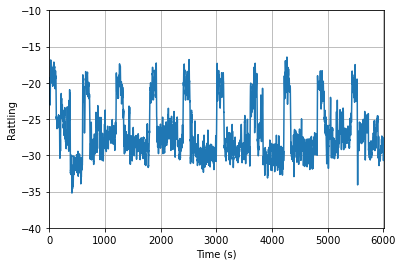

In [5]:
# Calculate rattling over windows of the time-series
dt = np.mean(np.diff(t_data))
T = 8; ov = 1; w_sz = int(T/dt); N = 25;
%time rats, covs, _ = rattling_windows(np.hstack([x,y,theta]),dt,w_sz,ov)

# Plotting
plt.figure()
plt.plot(t_data[:2-w_sz-N],moving_average(rats,N))
plt.xlabel('Time (s)')
plt.ylabel('Rattling')
plt.xlim([t_data[0],t_data[2-w_sz-N]])
plt.ylim([-40,-10])
plt.grid(True)
plt.show()

## Removing Random Shuffle Data
To visualize the driven steady-state of the system under a given drive we must remove the periods of randomization. To this end we make use of the synchronization pulses to differentiate between the initializations in the time-series.

In [6]:
# Sync times and trial begin times
offset = 0.45
t_sync_trim = t_sync[np.where(t_sync>0.01)[0]]+offset
trial_sync_inds = np.where(np.diff(t_sync_trim)>60)[0] # if the difference between time pulses exceeds 60 seconds 
                                                       # then we are in a different trial.
rand_times = np.vstack([np.array([0.0, t_data[np.max(np.where(t_data<=t_sync[0])[0])]]),
                        np.array([t_sync_trim[trial_sync_inds],t_sync_trim[trial_sync_inds+1]]).T])

# Removing random data
t_vec = np.copy(t_data)
x_vec = [x.T[i] for i in range(num_smarts)]
y_vec = [y.T[i] for i in range(num_smarts)]
theta_vec = [theta.T[i] for i in range(num_smarts)]
rat_vec = np.copy(rats)
for i in range(rand_times.shape[0]):
    rand_inds = np.where(np.logical_and(t_vec>=rand_times[i,0], t_vec<=rand_times[i,1]))
    t_vec = np.delete(t_vec,rand_inds)
    rat_vec = np.delete(rat_vec,rand_inds)
    for j in range(num_smarts):
        x_vec[j] = np.delete(x_vec[j],rand_inds)
        y_vec[j] = np.delete(y_vec[j],rand_inds)
        theta_vec[j] = np.delete(theta_vec[j],rand_inds)

# Trim vectors to make rattling vector same size
t_vec = np.copy(t_vec[:1-w_sz])
x_vec = list(np.array(x_vec).T[:1-w_sz].T)
y_vec = list(np.array(y_vec).T[:1-w_sz].T)
theta_vec = list(np.array(theta_vec).T[:1-w_sz].T)

## Trajectory Without Random
Now we can visualize the smarticle trajectories without the randomization between trials. 

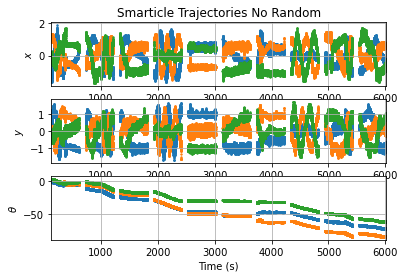

In [7]:
plt.figure()
plt.subplot(3,1,1)
plt.title('Smarticle Trajectories No Random')
plt.scatter(t_vec,x_vec[0],s=2)
plt.scatter(t_vec,x_vec[1],s=2)
plt.scatter(t_vec,x_vec[2],s=2)
plt.xlim([t_vec[0], t_vec[-1]])
plt.ylabel(r'$x$')
plt.grid(True)

plt.subplot(3,1,2)
plt.scatter(t_vec,y_vec[0],s=2)
plt.scatter(t_vec,y_vec[1],s=2)
plt.scatter(t_vec,y_vec[2],s=2)
plt.xlim([t_vec[0], t_vec[-1]])
plt.ylabel(r'$y$')
plt.grid(True)

plt.subplot(3,1,3)
plt.scatter(t_vec,theta_vec[0],s=2)
plt.scatter(t_vec,theta_vec[1],s=2)
plt.scatter(t_vec,theta_vec[2],s=2)
plt.xlim([t_vec[0], t_vec[-1]])
plt.ylabel(r'$\theta$')
plt.xlabel('Time (s)')
plt.grid(True)
plt.show()

## Period Times
Collect the time stamp indices at the beginning of each smarticle drive period.

In [8]:
inds = []
for i in range(1,len(t_sync_trim)):
    temp = np.where(t_sync_trim[i]<=t_vec)[0]
    if len(temp) > 0:
        inds.append(np.min(temp))

## Preprocessing Data
Calculate coordinate transformation to remove global rotation symmetry.

In [9]:
prep_data = np.vstack([x_vec[0],y_vec[0],theta_vec[0],x_vec[1],y_vec[1],theta_vec[1],x_vec[2],y_vec[2],theta_vec[2]]).T
%time observables = preprocess(prep_data)

Wall time: 1.98 s


## Driven Steady-State Plot
Here we construct a 3D scatter plot similar to those in the main manuscript. We plot the rotationally symmetric smarticle observables at the beginning of each driving period as colored by their measured rattling value.

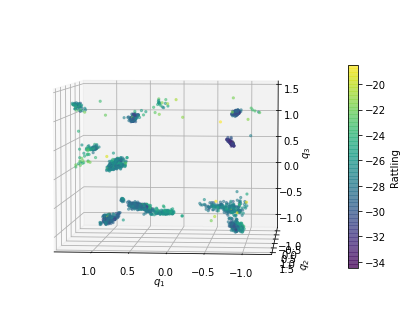

In [10]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
skip=1; offset = 30; col = rat_vec[inds[offset:-1:skip]]
im = ax.scatter(observables[inds[offset:-1:skip],1],observables[inds[offset:-1:skip],0],observables[inds[offset:-1:skip],2],c=col,s=5,alpha=0.5)
ax.view_init(elev=5, azim=95)
ax.set_xlabel(r'$q_1$')
ax.set_ylabel(r'$q_2$')
ax.set_zlabel(r'$q_3$')
cbar = fig.colorbar(im,shrink=0.6)
cbar.set_label('Rattling')
plt.tight_layout()
plt.show()

In [ ]:
plt.close('all')